### Unsupervised Learning Trading Strategy

- Download/Load S&P500 stocks prices data.
- Calculate different features and indicators on each stock
- Aggregate on monthly level and filter top 150 most liquid stocks.
- Calculate Monthly Returns for different time horizons.
- Download Fama-French Factors and Calculate Rolling Factor Betas.
- For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.
- For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization.
- Visualise Portfolio returns and compare to S&P500.

In [1]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
import warnings
import os
import pickle
warnings.filterwarnings("ignore")

### 1. Download/Load S&P500 stocks prices data

In [2]:
file_path = "Dataset/s_p_500_companies.csv"
if not os.path.exists(file_path):
    try:
        # Extract the s&p500 data from the wikipedia
        s_p_500_data = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")[0]

        s_p_500_data.to_csv("Dataset/s_p_500_companies.csv", index = False)
        print(f"Data saved in the location: {file_path}.")
    except Exception as e:
        print(f"Data can not be downloaded: {e}")
else:
    print(f"Data already downloaded at: {file_path}")

Data already downloaded at: Dataset/s_p_500_companies.csv


Now calling the dataset.

In [3]:
s_p_500_data = pd.read_csv(file_path)
s_p_500_data.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [4]:
s_p_500_data["Symbol"] = s_p_500_data["Symbol"].str.replace(".", "-")

symbols_list = s_p_500_data["Symbol"].unique().tolist()

In [5]:
symbols_list[:10]

['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A']

In [6]:
end_date = "2024-12-30"

# Taking the start date of 10 years before
start_date = pd.to_datetime(end_date) - pd.DateOffset(365*8)

In [7]:
print(f"Starting Date: {start_date}")
print(f"Ending Date: {end_date}")

Starting Date: 2017-01-01 00:00:00
Ending Date: 2024-12-30


In [8]:
def download_dataset():
    try:
        # Checking if the dataset exists or not
        if os.path.exists(path = "Dataset/data.pkl"):
            print("Dataset is already downloaded.")
        else:

            # Downloading data of all the tickers we got from web
            os.makedirs(name = "Dataset", exist_ok = True)
            dataset = yf.download(tickers = symbols_list,
                                  start = start_date,
                                  end = end_date)
            
            # Save the dataset as a pickle file
            with open("Dataset/data.pkl", "wb") as f:
                pickle.dump(dataset, f)
            print("Dataset downloaded and saved to 'Dataset/data.pkl'.")
    except Exception as e:
        raise e

In [9]:
download_dataset()

# Load the dataset from the pickle file
with open("Dataset/data.pkl", "rb") as f:
    dataset = pickle.load(f)

Dataset is already downloaded.


In [10]:
dataset.head()

Price           Close                                                   \
Ticker              A       AAPL       ABBV ABNB        ABT       ACGL   
Date                                                                     
2017-01-03  43.824730  26.891960  44.265282  NaN  33.788059  28.629999   
2017-01-04  44.399750  26.861856  44.889431  NaN  34.056305  28.833332   
2017-01-05  43.871861  26.998468  45.229893  NaN  34.350479  28.540001   
2017-01-06  45.238724  27.299450  45.244072  NaN  35.284946  28.823334   
2017-01-09  45.380131  27.549496  45.541965  NaN  35.250351  28.406668   

Price                                                     ...  Volume  \
Ticker             ACN        ADBE        ADI        ADM  ...     WTW   
Date                                                      ...           
2017-01-03  102.893745  103.480003  62.182297  37.087620  ...  789800   
2017-01-04  103.141121  104.139999  62.053673  37.023384  ...  477200   
2017-01-05  101.594978  105.910004  61.161808  36.750393  ...  583600   
2017-01-06  102.752396  108.300003  61.401924  35.907303  ...  812200   
2017-01-09  101.603828  108.570000  61.693504  35.931396  ...  467800   

Price                                                                       \
Ticker           WY     WYNN      XEL       XOM      XYL      YUM      ZBH   
Date                                                                         
2017-01-03  2650200  2703500  2065100  10360600  1596700  4793400  1422533   
2017-01-04  3678500  2598800  2542600   9434200  1703000  2835200  1547884   
2017-01-05  3548000  2507500  2611900  14443200  1846000  4040000  1497517   
2017-01-06  2679300  1858400  1707400  16518100  1561600  2863800  1875630   
2017-01-09  4017600  2776200  1840100  13762300  1090400  1944200  1198199   

Price                        
Ticker        ZBRA      ZTS  
Date                         
2017-01-03  388200  3579700  
2017-01-04  463200  3316300  
2017-01-05  486600  2469100  
2017-01-06  308300  2845800  
2017-01-09  263300  2123300  

[5 rows x 2515 columns]

In [11]:
dataset = dataset.stack()
dataset

Price                   Close        High         Low        Open       Volume
Date       Ticker                                                             
2017-01-03 A        43.824730   44.069823   43.117727   43.296833    1739600.0
           AAPL     26.891960   26.933635   26.570137   26.810926  115127600.0
           ABBV     44.265282   44.705026   43.931926   44.627006    9328200.0
           ABT      33.788059   33.814019   33.173732   33.424655    9677300.0
           ACGL     28.629999   29.143333   28.506666   28.943333     942900.0
...                       ...         ...         ...         ...          ...
2024-12-27 XYL     117.529999  119.099998  117.180000  117.599998     552400.0
           YUM     135.229996  136.470001  134.289993  135.139999    1146300.0
           ZBH     106.870003  107.629997  106.260002  106.449997     743400.0
           ZBRA    389.070007  394.700012  387.010010  393.369995     287200.0
           ZTS     164.600006  166.529999  163.520004  164.949997    1800100.0

[991254 rows x 5 columns]

In [12]:
dataset["Adj Close"] = dataset["Close"] * (dataset["Close"].iloc[-1] / dataset["Close"].iloc[-1])

In [13]:
dataset.columns = dataset.columns.str.lower()
dataset.head()

Price                  close       high        low       open       volume  \
Date       Ticker                                                            
2017-01-03 A       43.824730  44.069823  43.117727  43.296833    1739600.0   
           AAPL    26.891960  26.933635  26.570137  26.810926  115127600.0   
           ABBV    44.265282  44.705026  43.931926  44.627006    9328200.0   
           ABT     33.788059  33.814019  33.173732  33.424655    9677300.0   
           ACGL    28.629999  29.143333  28.506666  28.943333     942900.0   

Price              adj close  
Date       Ticker             
2017-01-03 A       43.824730  
           AAPL    26.891960  
           ABBV    44.265282  
           ABT     33.788059  
           ACGL    28.629999

### 2. Calculate Features and Technical Indicators for each Stock.

- Garman-Klass Volatility
- RSI
- Bollinger Bands
- ATR
- MACD
- Dollar Volumn

We will normalize every column (other than RSI column) as we will be passing the dataset to a Machine Learning Algorithm (K-Means).

#### Garman-Klass Volatility

$$
\text{Garman-Klass Volatility} = 
\frac{\left(\ln(\text{High}) - \ln(\text{Low})\right)^2}{2} - 
\left(2 \ln(2) - 1\right) \left(\ln(\text{Close}) - \ln(\text{Open})\right)^2
$$

In [14]:
# Calculate the Garman-Klass volatility
dataset["garman_klass_vol"] = 0.5 * ((np.log(dataset["high"]) - np.log(dataset["low"])) ** 2) - \
                             (2 * np.log(2) - 1) * ((np.log(dataset["close"]) - np.log(dataset["open"])) ** 2)

# View the first few rows of the dataset
dataset.head()

Price                  close       high        low       open       volume  \
Date       Ticker                                                            
2017-01-03 A       43.824730  44.069823  43.117727  43.296833    1739600.0   
           AAPL    26.891960  26.933635  26.570137  26.810926  115127600.0   
           ABBV    44.265282  44.705026  43.931926  44.627006    9328200.0   
           ABT     33.788059  33.814019  33.173732  33.424655    9677300.0   
           ACGL    28.629999  29.143333  28.506666  28.943333     942900.0   

Price              adj close  garman_klass_vol  
Date       Ticker                               
2017-01-03 A       43.824730          0.000182  
           AAPL    26.891960          0.000089  
           ABBV    44.265282          0.000127  
           ABT     33.788059          0.000138  
           ACGL    28.629999          0.000198

#### RSI

Here, we will be using the ta module.

In [15]:
import ta

In [16]:
# Calculating rsi with 20 days window
dataset["rsi"] = ta.momentum.RSIIndicator(dataset["close"], window = 20).rsi()

In [17]:
dataset.tail()

Price                   close        high         low        open     volume  \
Date       Ticker                                                              
2024-12-27 XYL     117.529999  119.099998  117.180000  117.599998   552400.0   
           YUM     135.229996  136.470001  134.289993  135.139999  1146300.0   
           ZBH     106.870003  107.629997  106.260002  106.449997   743400.0   
           ZBRA    389.070007  394.700012  387.010010  393.369995   287200.0   
           ZTS     164.600006  166.529999  163.520004  164.949997  1800100.0   

Price               adj close  garman_klass_vol        rsi  
Date       Ticker                                           
2024-12-27 XYL     117.529999          0.000132  49.255354  
           YUM     135.229996          0.000129  49.592167  
           ZBH     106.870003          0.000076  49.043150  
           ZBRA    389.070007          0.000147  54.338016  
           ZTS     164.600006          0.000165  49.988875

We can check if the RSI is implemented correctly or not just by plotting it.

<Axes: xlabel='Date'>

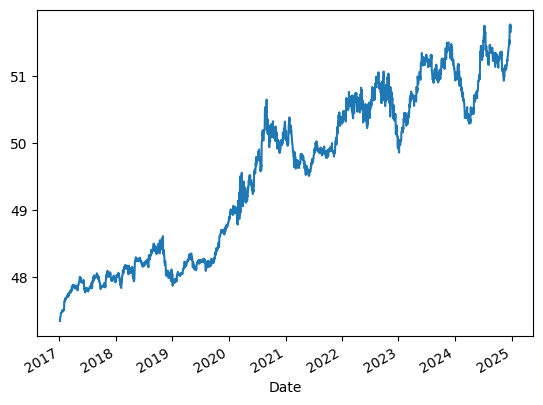

In [18]:
# With this we are plotting the average RSI over the years for "AAPL"
dataset.xs("AAPL", level = 1)["rsi"].plot()

#### Bollinger's Bands

In [19]:
import ta.volatility

def calculate_bollinger_bands(dataset):
    close_log = np.log1p(dataset["close"])
    bb = ta.volatility.BollingerBands(close = close_log, window = 20)
    dataset["bb_low"] = bb.bollinger_lband()
    dataset["bb_mid"] = bb.bollinger_mavg()
    dataset["bb_high"] = bb.bollinger_hband()

    return dataset

dataset = calculate_bollinger_bands(dataset)

In [20]:
dataset

Price                   close        high         low        open  \
Date       Ticker                                                   
2017-01-03 A        43.824730   44.069823   43.117727   43.296833   
           AAPL     26.891960   26.933635   26.570137   26.810926   
           ABBV     44.265282   44.705026   43.931926   44.627006   
           ABT      33.788059   33.814019   33.173732   33.424655   
           ACGL     28.629999   29.143333   28.506666   28.943333   
...                       ...         ...         ...         ...   
2024-12-27 XYL     117.529999  119.099998  117.180000  117.599998   
           YUM     135.229996  136.470001  134.289993  135.139999   
           ZBH     106.870003  107.629997  106.260002  106.449997   
           ZBRA    389.070007  394.700012  387.010010  393.369995   
           ZTS     164.600006  166.529999  163.520004  164.949997   

Price                   volume   adj close  garman_klass_vol        rsi  \
Date       Ticker                                                         
2017-01-03 A         1739600.0   43.824730          0.000182        NaN   
           AAPL    115127600.0   26.891960          0.000089        NaN   
           ABBV      9328200.0   44.265282          0.000127        NaN   
           ABT       9677300.0   33.788059          0.000138        NaN   
           ACGL       942900.0   28.629999          0.000198        NaN   
...                        ...         ...               ...        ...   
2024-12-27 XYL        552400.0  117.529999          0.000132  49.255354   
           YUM       1146300.0  135.229996          0.000129  49.592167   
           ZBH        743400.0  106.870003          0.000076  49.043150   
           ZBRA       287200.0  389.070007          0.000147  54.338016   
           ZTS       1800100.0  164.600006          0.000165  49.988875   

Price                bb_low    bb_mid   bb_high  
Date       Ticker                                
2017-01-03 A            NaN       NaN       NaN  
           AAPL         NaN       NaN       NaN  
           ABBV         NaN       NaN       NaN  
           ABT          NaN       NaN       NaN  
           ACGL         NaN       NaN       NaN  
...                     ...       ...       ...  
2024-12-27 XYL     2.588351  4.523441  6.458530  
           YUM     2.591703  4.506023  6.420343  
           ZBH     2.640737  4.443643  6.246550  
           ZBRA    2.975098  4.623823  6.272547  
           ZTS     3.433314  4.756708  6.080102  

[991254 rows x 11 columns]

#### ATR (Average True Range)

In [21]:
def calculate_atr(dataset):
    atr = ta.volatility.AverageTrueRange(
        high = dataset["high"],
        low = dataset["low"],
        close = dataset["close"],
        window = 20
    ).average_true_range()

    dataset["atr"] = (atr - atr.mean()) / atr.std()

    return dataset

dataset = calculate_atr(dataset)

In [22]:
dataset.tail()

Price                   close        high         low        open     volume  \
Date       Ticker                                                              
2024-12-27 XYL     117.529999  119.099998  117.180000  117.599998   552400.0   
           YUM     135.229996  136.470001  134.289993  135.139999  1146300.0   
           ZBH     106.870003  107.629997  106.260002  106.449997   743400.0   
           ZBRA    389.070007  394.700012  387.010010  393.369995   287200.0   
           ZTS     164.600006  166.529999  163.520004  164.949997  1800100.0   

Price               adj close  garman_klass_vol        rsi    bb_low  \
Date       Ticker                                                      
2024-12-27 XYL     117.529999          0.000132  49.255354  2.588351   
           YUM     135.229996          0.000129  49.592167  2.591703   
           ZBH     106.870003          0.000076  49.043150  2.640737   
           ZBRA    389.070007          0.000147  54.338016  2.975098   
           ZTS     164.600006          0.000165  49.988875  3.433314   

Price                bb_mid   bb_high       atr  
Date       Ticker                                
2024-12-27 XYL     4.523441  6.458530 -0.002148  
           YUM     4.506023  6.420343 -0.064068  
           ZBH     4.443643  6.246550 -0.117792  
           ZBRA    4.623823  6.272547 -0.037242  
           ZTS     4.756708  6.080102  0.007621

#### MACD

In [23]:
import ta.trend

def compute_macd(dataset):
    macd = ta.trend.MACD(close = dataset["close"],
                         window_slow = 26,
                         window_fast = 12,
                         window_sign = 9).macd()
    
    macd = (macd - macd.mean())/ macd.std()
    dataset["macd"] = macd
    return dataset

dataset = compute_macd(dataset)

In [24]:
dataset.tail()

Price                   close        high         low        open     volume  \
Date       Ticker                                                              
2024-12-27 XYL     117.529999  119.099998  117.180000  117.599998   552400.0   
           YUM     135.229996  136.470001  134.289993  135.139999  1146300.0   
           ZBH     106.870003  107.629997  106.260002  106.449997   743400.0   
           ZBRA    389.070007  394.700012  387.010010  393.369995   287200.0   
           ZTS     164.600006  166.529999  163.520004  164.949997  1800100.0   

Price               adj close  garman_klass_vol        rsi    bb_low  \
Date       Ticker                                                      
2024-12-27 XYL     117.529999          0.000132  49.255354  2.588351   
           YUM     135.229996          0.000129  49.592167  2.591703   
           ZBH     106.870003          0.000076  49.043150  2.640737   
           ZBRA    389.070007          0.000147  54.338016  2.975098   
           ZTS     164.600006          0.000165  49.988875  3.433314   

Price                bb_mid   bb_high       atr      macd  
Date       Ticker                                          
2024-12-27 XYL     4.523441  6.458530 -0.002148 -0.541987  
           YUM     4.506023  6.420343 -0.064068 -0.475401  
           ZBH     4.443643  6.246550 -0.117792 -0.485367  
           ZBRA    4.623823  6.272547 -0.037242  0.184530  
           ZTS     4.756708  6.080102  0.007621  0.172609

#### Dollar Volume

In [25]:
dataset["dollar_vol"] = (dataset["adj close"] * dataset["volume"]) / 1e6

In [26]:
dataset.tail()

Price                   close        high         low        open     volume  \
Date       Ticker                                                              
2024-12-27 XYL     117.529999  119.099998  117.180000  117.599998   552400.0   
           YUM     135.229996  136.470001  134.289993  135.139999  1146300.0   
           ZBH     106.870003  107.629997  106.260002  106.449997   743400.0   
           ZBRA    389.070007  394.700012  387.010010  393.369995   287200.0   
           ZTS     164.600006  166.529999  163.520004  164.949997  1800100.0   

Price               adj close  garman_klass_vol        rsi    bb_low  \
Date       Ticker                                                      
2024-12-27 XYL     117.529999          0.000132  49.255354  2.588351   
           YUM     135.229996          0.000129  49.592167  2.591703   
           ZBH     106.870003          0.000076  49.043150  2.640737   
           ZBRA    389.070007          0.000147  54.338016  2.975098   
           ZTS     164.600006          0.000165  49.988875  3.433314   

Price                bb_mid   bb_high       atr      macd  dollar_vol  
Date       Ticker                                                      
2024-12-27 XYL     4.523441  6.458530 -0.002148 -0.541987   64.923571  
           YUM     4.506023  6.420343 -0.064068 -0.475401  155.014144  
           ZBH     4.443643  6.246550 -0.117792 -0.485367   79.447160  
           ZBRA    4.623823  6.272547 -0.037242  0.184530  111.740906  
           ZTS     4.756708  6.080102  0.007621  0.172609  296.296471

### 3. Aggregate to monthly level and filter top 150 most liquid stocks for each month.

We will only be aggregating the Dollar Vol column by mean.

In [27]:
dollar_df = dataset.unstack("Ticker")["dollar_vol"].resample("M").mean() \
                   .stack("Ticker")\
                   .to_frame("dollar_vol")

Now we will be getting the last technical columns.

In [28]:
last_cols = [c for c in dataset.columns.unique(0) if c not in ["close", "high", "low", "open", "volume", "dollar_vol"]]

last_cols

['adj close',
 'garman_klass_vol',
 'rsi',
 'bb_low',
 'bb_mid',
 'bb_high',
 'atr',
 'macd']

In [29]:
last_df = dataset.unstack()[last_cols].resample("M").last()\
                 .stack("Ticker")

last_df

Price               adj close  garman_klass_vol        rsi    bb_low  \
Date       Ticker                                                      
2017-01-31 A        46.162552          0.000133  48.759523  2.807772   
           AAPL     28.095900          0.000019  47.516672  2.753155   
           ABBV     43.780571          0.000209  48.711361  2.751118   
           ABT      36.375000          0.000172  48.166435  2.732506   
           ACGL     29.450001          0.000141  47.641829  2.696891   
...                       ...               ...        ...       ...   
2024-12-31 XYL     117.529999          0.000132  49.255354  2.588351   
           YUM     135.229996          0.000129  49.592167  2.591703   
           ZBH     106.870003          0.000076  49.043150  2.640737   
           ZBRA    389.070007          0.000147  54.338016  2.975098   
           ZTS     164.600006          0.000165  49.988875  3.433314   

Price                bb_mid   bb_high       atr      macd  
Date       Ticker                                          
2017-01-31 A       3.902753  4.997735 -1.056715 -0.015940  
           AAPL    3.857465  4.961775 -1.066264 -0.093065  
           ABBV    3.855667  4.960217 -1.076556 -0.115071  
           ABT     3.841441  4.950376 -1.090100 -0.148640  
           ACGL    3.821257  4.945623 -1.103579 -0.189742  
...                     ...       ...       ...       ...  
2024-12-31 XYL     4.523441  6.458530 -0.002148 -0.541987  
           YUM     4.506023  6.420343 -0.064068 -0.475401  
           ZBH     4.443643  6.246550 -0.117792 -0.485367  
           ZBRA    4.623823  6.272547 -0.037242  0.184530  
           ZTS     4.756708  6.080102  0.007621  0.172609  

[47351 rows x 8 columns]

In [30]:
data = (pd.concat([dollar_df, last_df], axis = 1)).dropna()

data

dollar_vol   adj close  garman_klass_vol        rsi  \
Date       Ticker                                                         
2017-01-31 A        102.349491   46.162552          0.000133  48.759523   
           AAPL    3120.691209   28.095900          0.000019  47.516672   
           ABBV     344.889460   43.780571          0.000209  48.711361   
           ABT      371.924574   36.375000          0.000172  48.166435   
           ACGL      31.221116   29.450001          0.000141  47.641829   
...                        ...         ...               ...        ...   
2024-12-31 XYL      171.276104  117.529999          0.000132  49.255354   
           YUM      211.836009  135.229996          0.000129  49.592167   
           ZBH      166.049109  106.870003          0.000076  49.043150   
           ZBRA     123.142438  389.070007          0.000147  54.338016   
           ZTS      425.869521  164.600006          0.000165  49.988875   

                     bb_low    bb_mid   bb_high       atr      macd  
Date       Ticker                                                    
2017-01-31 A       2.807772  3.902753  4.997735 -1.056715 -0.015940  
           AAPL    2.753155  3.857465  4.961775 -1.066264 -0.093065  
           ABBV    2.751118  3.855667  4.960217 -1.076556 -0.115071  
           ABT     2.732506  3.841441  4.950376 -1.090100 -0.148640  
           ACGL    2.696891  3.821257  4.945623 -1.103579 -0.189742  
...                     ...       ...       ...       ...       ...  
2024-12-31 XYL     2.588351  4.523441  6.458530 -0.002148 -0.541987  
           YUM     2.591703  4.506023  6.420343 -0.064068 -0.475401  
           ZBH     2.640737  4.443643  6.246550 -0.117792 -0.485367  
           ZBRA    2.975098  4.623823  6.272547 -0.037242  0.184530  
           ZTS     3.433314  4.756708  6.080102  0.007621  0.172609  

[47351 rows x 9 columns]

Calculate 5-year rolling average of dollar volume for each stocks before filtering.

In [31]:
data["dollar_vol"] = (data.loc[:, "dollar_vol"].unstack("Ticker").rolling(5*12, min_periods = 12).mean()\
                                               .stack())

In [32]:
data["dollar_vol_rank"] = (data.groupby("Date")["dollar_vol"].rank(ascending = False))

In [33]:
data = data[data["dollar_vol_rank"] < 150].drop(["dollar_vol", "dollar_vol_rank"], axis = 1)

data

adj close  garman_klass_vol        rsi    bb_low  \
Date       Ticker                                                      
2017-12-31 AAPL     39.811531          0.000010  47.923944  2.924965   
           ABBV     71.096024          0.000072  49.733749  2.935639   
           ABT      50.525513          0.000041  48.565556  2.937664   
           ACN     137.983582          0.000019  53.586241  2.854517   
           ADBE    175.240005          0.000056  55.489110  2.967762   
...                       ...               ...        ...       ...   
2024-12-31 WDAY    266.239990          0.000173  50.918878  2.233878   
           WFC      71.110001          0.000121  48.415100  2.306661   
           WMT      91.660004          0.000094  48.786533  2.378780   
           XOM     106.480003          0.000215  49.053463  2.507511   
           ZTS     164.600006          0.000165  49.988875  3.433314   

                     bb_mid   bb_high       atr      macd  
Date       Ticker                                          
2017-12-31 AAPL    4.065633  5.206301 -0.964566 -0.075088  
           ABBV    4.079538  5.223437 -0.971447 -0.068807  
           ABT     4.080862  5.224060 -0.984072 -0.112099  
           ACN     4.085566  5.316616 -0.962604  0.002377  
           ADBE    4.191144  5.414525 -0.966311  0.244179  
...                     ...       ...       ...       ...  
2024-12-31 WDAY    4.670666  7.107453  0.598586 -0.736550  
           WFC     4.506132  6.705602  0.370304 -1.014998  
           WMT     4.557193  6.735607  0.267034 -0.909707  
           XOM     4.470263  6.433016  0.066411 -0.565280  
           ZTS     4.756708  6.080102  0.007621  0.172609  

[12665 rows x 8 columns]

### 4. Calculate Monthly Returns for different time horizons as features

- To capture time series dynamics that reflects, for example, momentum patterns, we compute historical returns using the method .pct_change(lag), that is, returns over various monthly periods as identified by lags.

In [34]:
def calculate_returns(df):
    outlier_cutoff = 0.005
    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:
        data[f"return_{lag}m"] = (df["adj close"]
                                  .pct_change(lag)
                                  .pipe(lambda x: x.clip(lower = x.quantile(outlier_cutoff),
                                                         upper = x.quantile(1-outlier_cutoff)))
                                  .add(1)
                                  .pow(1/lag)
                                  .sub(1))
    
    return df

In [35]:
data = calculate_returns(data).dropna()

In [36]:
data

adj close  garman_klass_vol        rsi    bb_low  \
Date       Ticker                                                      
2017-12-31 AMT     120.305420          0.000020  52.405498  2.369671   
           AMZN     58.473499          0.000052  48.694751  2.361126   
           AVGO     20.514519          0.000162  47.154811  2.232394   
           AXP      90.060097          0.000031  50.628502  2.738634   
           AZO     711.369995          0.000068  69.362646  2.510877   
...                       ...               ...        ...       ...   
2024-12-31 WDAY    266.239990          0.000173  50.918878  2.233878   
           WFC      71.110001          0.000121  48.415100  2.306661   
           WMT      91.660004          0.000094  48.786533  2.378780   
           XOM     106.480003          0.000215  49.053463  2.507511   
           ZTS     164.600006          0.000165  49.988875  3.433314   

                     bb_mid   bb_high       atr      macd  return_1m  \
Date       Ticker                                                      
2017-12-31 AMT     4.087728  5.805784 -0.991496  0.251911  -0.151955   
           AMZN    4.058913  5.756699 -0.982094  0.153575  -0.513958   
           AVGO    4.036910  5.841427 -0.887319 -0.043728  -0.649166   
           AXP     4.184847  5.631061 -0.884063 -0.058427   3.390066   
           AZO     4.263455  6.016033 -0.591450  1.462063   6.898837   
...                     ...       ...       ...       ...        ...   
2024-12-31 WDAY    4.670666  7.107453  0.598586 -0.736550   5.669339   
           WFC     4.506132  6.705602  0.370304 -1.014998  -0.732910   
           WMT     4.557193  6.735607  0.267034 -0.909707   0.288989   
           XOM     4.470263  6.433016  0.066411 -0.565280   0.161684   
           ZTS     4.756708  6.080102  0.007621  0.172609   0.545830   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
Date       Ticker                                                          
2017-12-31 AMT      2.420945   0.365418   0.029328  -0.015118    0.096536  
           AMZN    -0.357983   0.785070  -0.092711  -0.114811   -0.016156  
           AVGO    -0.587059  -0.475114  -0.136395  -0.137953   -0.072361  
           AXP      0.241043  -0.092007   0.113458  -0.012820   -0.034930  
           AZO      4.888668   1.299917   0.817198   0.237089    0.123842  
...                      ...        ...        ...        ...         ...  
2024-12-31 WDAY    -0.192946   0.305785   0.024738   0.115377    0.014871  
           WFC      0.334658  -0.441760  -0.091071   0.016945   -0.139537  
           WMT     -0.413250   0.319258  -0.187527  -0.173620   -0.059422  
           XOM      0.223682  -0.263231  -0.019152  -0.081979    0.005540  
           ZTS      0.340062   0.322817  -0.140669   0.030038    0.086045  

[12653 rows x 14 columns]

In [37]:
factor_data = web.DataReader("F-F_Research_Data_5_Factors_2x3",
                             "famafrench",
                             start = "2010")[0].drop("RF", axis = 1)

In [38]:
factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample("M").last().div(100)

In [39]:
factor_data

,Mkt-RF,SMB,HML,RMW,CMA
Date,,,,,
2010-01-31,-0.0336,0.0034,0.0043,-0.0127,0.0046
2010-02-28,0.0340,0.0151,0.0322,-0.0027,0.0142
2010-03-31,0.0631,0.0185,0.0221,-0.0065,0.0169
2010-04-30,0.0200,0.0498,0.0289,0.0069,0.0172
2010-05-31,-0.0789,0.0005,-0.0244,0.0130,-0.0022
...,...,...,...,...,...
2024-07-31,0.0124,0.0828,0.0574,0.0022,0.0043
2024-08-31,0.0161,-0.0365,-0.0113,0.0085,0.0086
2024-09-30,0.0174,-0.0102,-0.0259,0.0004,-0.0026


In [40]:
factor_data = factor_data.join(data["return_1m"]).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
Date       Ticker                                                   
2017-12-31 AMT     0.0106 -0.0106  0.0006  0.0075  0.0170  -0.151955
           AMZN    0.0106 -0.0106  0.0006  0.0075  0.0170  -0.513958
           AVGO    0.0106 -0.0106  0.0006  0.0075  0.0170  -0.649166
           AXP     0.0106 -0.0106  0.0006  0.0075  0.0170   3.390066
           AZO     0.0106 -0.0106  0.0006  0.0075  0.0170   6.898837
...                   ...     ...     ...     ...     ...        ...
2024-11-30 WDAY    0.0650  0.0478 -0.0005 -0.0261 -0.0217   4.638024
           WFC     0.0650  0.0478 -0.0005 -0.0261 -0.0217  -0.695308
           WMT     0.0650  0.0478 -0.0005 -0.0261 -0.0217   0.211704
           XOM     0.0650  0.0478 -0.0005 -0.0261 -0.0217   0.278069
           ZTS     0.0650  0.0478 -0.0005 -0.0261 -0.0217   0.485673

[12504 rows x 6 columns]

- Filter out stocks with less than 10 months of data.

In [41]:
observations = factor_data.groupby("Ticker").size()

In [42]:
valid_stocks = observations[observations >= 10]

valid_stocks

Ticker
AAPL    83
ABBV    83
ABNB    37
ABT     83
ACN     83
        ..
WDC     54
WFC     84
WMT     84
WYNN    68
XOM     84
Length: 173, dtype: int64

In [43]:
factor_data = factor_data[factor_data.index.get_level_values("Ticker").isin(valid_stocks.index)]
factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
Date       Ticker                                                   
2017-12-31 AMT     0.0106 -0.0106  0.0006  0.0075  0.0170  -0.151955
           AMZN    0.0106 -0.0106  0.0006  0.0075  0.0170  -0.513958
           AVGO    0.0106 -0.0106  0.0006  0.0075  0.0170  -0.649166
           AXP     0.0106 -0.0106  0.0006  0.0075  0.0170   3.390066
           AZO     0.0106 -0.0106  0.0006  0.0075  0.0170   6.898837
...                   ...     ...     ...     ...     ...        ...
2024-11-30 VZ      0.0650  0.0478 -0.0005 -0.0261 -0.0217  -0.905283
           WDAY    0.0650  0.0478 -0.0005 -0.0261 -0.0217   4.638024
           WFC     0.0650  0.0478 -0.0005 -0.0261 -0.0217  -0.695308
           WMT     0.0650  0.0478 -0.0005 -0.0261 -0.0217   0.211704
           XOM     0.0650  0.0478 -0.0005 -0.0261 -0.0217   0.278069

[12431 rows x 6 columns]

- Calculate Rolling Factor Betas

In [44]:
betas = (factor_data.groupby("Ticker",
                             group_keys = False)
                    .apply(lambda x: RollingOLS(endog = x["return_1m"],
                                                exog = sm.add_constant(x.drop("return_1m", axis = 1)),
                                                window = min(24, x.shape[0]),
                                                min_nobs = len(x.columns)+1)
                    .fit(params_only = True)
                    .params
                    .drop("const", axis = 1)))

betas

Mkt-RF        SMB        HML        RMW        CMA
Date       Ticker                                                      
2017-12-31 AMT          NaN        NaN        NaN        NaN        NaN
           AMZN         NaN        NaN        NaN        NaN        NaN
           AVGO         NaN        NaN        NaN        NaN        NaN
           AXP          NaN        NaN        NaN        NaN        NaN
           AZO          NaN        NaN        NaN        NaN        NaN
...                     ...        ...        ...        ...        ...
2024-11-30 VZ     -0.056451   0.127108  -0.289628  -0.040525   0.244844
           WDAY    3.619894 -23.039175  32.000188 -15.850137 -30.377280
           WFC    -0.110881   0.767916  -0.582368   0.285757   0.552496
           WMT    -0.062666  -0.506966  -0.731237   1.096270   0.782496
           XOM    -1.280531  -9.279512  14.589689  -4.612885 -12.167705

[12431 rows x 5 columns]

In [45]:
data = data.join(betas.groupby("Ticker").shift())

In [46]:
factors = ["Mkt-RF", "SMB",	"HML", "RMW", "CMA"]

data.loc[:, factors] = data.groupby("Ticker", group_keys = False)[factors].apply(lambda x: x.fillna(x.mean()))

data

adj close  garman_klass_vol        rsi    bb_low  \
Date       Ticker                                                      
2017-12-31 AMT     120.305420          0.000020  52.405498  2.369671   
           AMZN     58.473499          0.000052  48.694751  2.361126   
           AVGO     20.514519          0.000162  47.154811  2.232394   
           AXP      90.060097          0.000031  50.628502  2.738634   
           AZO     711.369995          0.000068  69.362646  2.510877   
...                       ...               ...        ...       ...   
2024-12-31 WDAY    266.239990          0.000173  50.918878  2.233878   
           WFC      71.110001          0.000121  48.415100  2.306661   
           WMT      91.660004          0.000094  48.786533  2.378780   
           XOM     106.480003          0.000215  49.053463  2.507511   
           ZTS     164.600006          0.000165  49.988875  3.433314   

                     bb_mid   bb_high       atr      macd  return_1m  \
Date       Ticker                                                      
2017-12-31 AMT     4.087728  5.805784 -0.991496  0.251911  -0.151955   
           AMZN    4.058913  5.756699 -0.982094  0.153575  -0.513958   
           AVGO    4.036910  5.841427 -0.887319 -0.043728  -0.649166   
           AXP     4.184847  5.631061 -0.884063 -0.058427   3.390066   
           AZO     4.263455  6.016033 -0.591450  1.462063   6.898837   
...                     ...       ...       ...       ...        ...   
2024-12-31 WDAY    4.670666  7.107453  0.598586 -0.736550   5.669339   
           WFC     4.506132  6.705602  0.370304 -1.014998  -0.732910   
           WMT     4.557193  6.735607  0.267034 -0.909707   0.288989   
           XOM     4.470263  6.433016  0.066411 -0.565280   0.161684   
           ZTS     4.756708  6.080102  0.007621  0.172609   0.545830   

                   return_2m  return_3m  return_6m  return_9m  return_12m  \
Date       Ticker                                                           
2017-12-31 AMT      2.420945   0.365418   0.029328  -0.015118    0.096536   
           AMZN    -0.357983   0.785070  -0.092711  -0.114811   -0.016156   
           AVGO    -0.587059  -0.475114  -0.136395  -0.137953   -0.072361   
           AXP      0.241043  -0.092007   0.113458  -0.012820   -0.034930   
           AZO      4.888668   1.299917   0.817198   0.237089    0.123842   
...                      ...        ...        ...        ...         ...   
2024-12-31 WDAY    -0.192946   0.305785   0.024738   0.115377    0.014871   
           WFC      0.334658  -0.441760  -0.091071   0.016945   -0.139537   
           WMT     -0.413250   0.319258  -0.187527  -0.173620   -0.059422   
           XOM      0.223682  -0.263231  -0.019152  -0.081979    0.005540   
           ZTS      0.340062   0.322817  -0.140669   0.030038    0.086045   

                     Mkt-RF        SMB        HML        RMW        CMA  
Date       Ticker                                                        
2017-12-31 AMT    -0.125182  -0.335663  -0.203112   0.550019  -0.100023  
           AMZN    0.288959  -0.312319   0.867547  -0.108171  -0.858983  
           AVGO   -0.045587  -0.308900   0.270510  -0.265501  -0.211296  
           AXP     0.097030  -3.290829  -0.099249  -4.253959   2.781971  
           AZO    -3.417874  11.269477 -12.227233  22.940484   5.463199  
...                     ...        ...        ...        ...        ...  
2024-12-31 WDAY    1.858608  -3.382337   6.496414  -1.903940 -10.903220  
           WFC     0.012060  -2.027822   1.131071  -1.608941   0.691587  
           WMT    -0.109998   3.584767  -2.533045   3.070637   0.894159  
           XOM    -0.561328  -1.643722   2.198829  -0.464491  -1.322156  
           ZTS          NaN        NaN        NaN        NaN        NaN  

[12653 rows x 19 columns]

In [47]:
data = data.drop("adj close", axis = 1)
data = data.dropna()
data

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
Date       Ticker                                                              
2017-12-31 AMT             0.000020  52.405498  2.369671  4.087728  5.805784   
           AMZN            0.000052  48.694751  2.361126  4.058913  5.756699   
           AVGO            0.000162  47.154811  2.232394  4.036910  5.841427   
           AXP             0.000031  50.628502  2.738634  4.184847  5.631061   
           AZO             0.000068  69.362646  2.510877  4.263455  6.016033   
...                             ...        ...       ...       ...       ...   
2024-12-31 VZ              0.000081  47.819774  2.858053  4.929311  7.000569   
           WDAY            0.000173  50.918878  2.233878  4.670666  7.107453   
           WFC             0.000121  48.415100  2.306661  4.506132  6.705602   
           WMT             0.000094  48.786533  2.378780  4.557193  6.735607   
           XOM             0.000215  49.053463  2.507511  4.470263  6.433016   

                        atr      macd  return_1m  return_2m  return_3m  \
Date       Ticker                                                        
2017-12-31 AMT    -0.991496  0.251911  -0.151955   2.420945   0.365418   
           AMZN   -0.982094  0.153575  -0.513958  -0.357983   0.785070   
           AVGO   -0.887319 -0.043728  -0.649166  -0.587059  -0.475114   
           AXP    -0.884063 -0.058427   3.390066   0.241043  -0.092007   
           AZO    -0.591450  1.462063   6.898837   4.888668   1.299917   
...                     ...       ...        ...        ...        ...   
2024-12-31 VZ      0.619563 -1.154369  -0.902339  -0.422215  -0.499634   
           WDAY    0.598586 -0.736550   5.669339  -0.192946   0.305785   
           WFC     0.370304 -1.014998  -0.732910   0.334658  -0.441760   
           WMT     0.267034 -0.909707   0.288989  -0.413250   0.319258   
           XOM     0.066411 -0.565280   0.161684   0.223682  -0.263231   

                   return_6m  return_9m  return_12m    Mkt-RF        SMB  \
Date       Ticker                                                          
2017-12-31 AMT      0.029328  -0.015118    0.096536 -0.125182  -0.335663   
           AMZN    -0.092711  -0.114811   -0.016156  0.288959  -0.312319   
           AVGO    -0.136395  -0.137953   -0.072361 -0.045587  -0.308900   
           AXP      0.113458  -0.012820   -0.034930  0.097030  -3.290829   
           AZO      0.817198   0.237089    0.123842 -3.417874  11.269477   
...                      ...        ...         ...       ...        ...   
2024-12-31 VZ      -0.345959  -0.159735   -0.193362 -0.058091  -0.364430   
           WDAY     0.024738   0.115377    0.014871  1.858608  -3.382337   
           WFC     -0.091071   0.016945   -0.139537  0.012060  -2.027822   
           WMT     -0.187527  -0.173620   -0.059422 -0.109998   3.584767   
           XOM     -0.019152  -0.081979    0.005540 -0.561328  -1.643722   

                         HML        RMW        CMA  
Date       Ticker                                   
2017-12-31 AMT     -0.203112   0.550019  -0.100023  
           AMZN     0.867547  -0.108171  -0.858983  
           AVGO     0.270510  -0.265501  -0.211296  
           AXP     -0.099249  -4.253959   2.781971  
           AZO    -12.227233  22.940484   5.463199  
...                      ...        ...        ...  
2024-12-31 VZ       0.453987  -0.199495  -0.461087  
           WDAY     6.496414  -1.903940 -10.903220  
           WFC      1.131071  -1.608941   0.691587  
           WMT     -2.533045   3.070637   0.894159  
           XOM      2.198829  -0.464491  -1.322156  

[12425 rows x 18 columns]

In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 12425 entries, (Timestamp('2017-12-31 00:00:00'), 'AMT') to (Timestamp('2024-12-31 00:00:00'), 'XOM')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  12425 non-null  float64
 1   rsi               12425 non-null  float64
 2   bb_low            12425 non-null  float64
 3   bb_mid            12425 non-null  float64
 4   bb_high           12425 non-null  float64
 5   atr               12425 non-null  float64
 6   macd              12425 non-null  float64
 7   return_1m         12425 non-null  float64
 8   return_2m         12425 non-null  float64
 9   return_3m         12425 non-null  float64
 10  return_6m         12425 non-null  float64
 11  return_9m         12425 non-null  float64
 12  return_12m        12425 non-null  float64
 13  Mkt-RF            12425 non-null  float64
 14  SMB               12425 non-null  float64
 15  HML        